# Expected Epidemic Size of Mask Model

$P(A_{L, 0}) = f_0(P(A_{L - 1, 0}), P(A_{L - 1, 1}))$

$P(A_{L, 1}) = f_1(P(A_{L - 1, 0}), P(A_{L - 1, 1}))$

$P(\text{wear a mask}) = m$

$A_{L, 0}$ := Node v becomes **active** at level L given he **wear** a mask

$A_{L, 1}$ := Node v becomes **active** at level L given he **doesn't wears** a mask


## 1. Condition on num of neighbors from lower level







$B_k$ := Node v has $k - 1$ lower level neighbors

$P(A_{L, i}) = \sum_{k = 0}^{\infty}{P(A_{L, i} | B_k) * P(B_k)}$

where

$i = 0,1$

$P(B_k) = \frac{k p_{k}}{\langle k\rangle}$




## 2. Condition on num of neighbors wearing a mask

$N$ := Num of neighbors wearing masks 
 
$N \sim \operatorname{Binomial}\left(k - 1, m\right)$


$ P(A_{L, i} | B_k) = \sum_{n = 0}^{k - 1} P(A_{L, i} | B_k, N = n) * \left(\begin{array}{c}
k - 1 \\
n
\end{array}\right) * m^{n} * (1 - m)^{k - 1 - n} $

## 3. Condition on num of active lower level neighbors

$I_0$ := $I_0$ of $k-1$ lower level neighbors active and wear masks

$I_1$ := $I_1$ of $k-1$ lower level neighbors active and don't wear masks

$I_0 \sim \operatorname{Binomial}\left(n, P(A_{L-1,0})\right)$

$I_1 \sim \operatorname{Binomial}\left(k - 1 - n, P(A_{L-1,1})\right)$


$P(A_{L, i} | B_k, N = n) = \sum_{k_0 = 0}^{n}\sum_{k_1 = 0}^{k-1-n}P(A_{L, i} | B_k, N = n, I_0 = k_0, I_1 = k_1) * \left(\begin{array}{c}
n \\
k_0
\end{array}\right) \left(\begin{array}{c}
k - 1 - n \\
k_1
\end{array}\right) * P(A_{L-1, 0})^{k_0} * (1 - P(A_{L-1,0}))^{n - k_0} * P(A_{L-1, 1})^{k_1} * (1 - P(A_{L-1, 1}))^{k - 1 - n - k_1}$

where

$i = 0,1$

## 4. $P(A_{L, i} | B_k, N = n, I_0 = k_0, I_1 = k_1)$

$R$ := $B_k, N = n, I_0 = k_0, I_1 = k_1$

### 4.1 $P(A_{L,0} | R)$

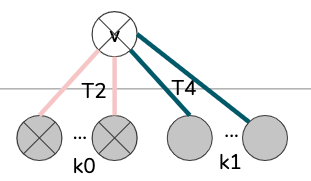

$P(A_{L,0} | R)$

$ = P(\text{At least 1 of node v's active neighbors succssfully infects it, given node v wears a mask} | R)$

$ = 1 - (1 - T_2)^{k_0} * (1 - T_4)^{k_1}$

### 4.1 $P(A_{L,1} | R)$

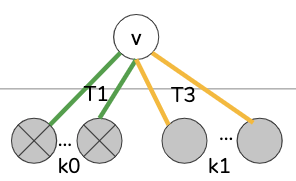

$P(A_{L,1} | R)$

$ = P(\text{At least 1 of node v's active neighbors succssfully infects it, given node v doesn't a mask} | R)$

$ = 1 - (1 - T_1)^{k_0} * (1 - T_3)^{k_1}$

T_mask1 : outward effeciency of masks

T_mask2 : inward effeciency of masks

In [1]:
from os import listdir
from os.path import isfile, join
import json
from operator import mul    # or mul=lambda x,y:x*y
from fractions import Fraction
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import poisson
from scipy.special import comb
from scipy import optimize 
import multiprocessing, time
from multiprocessing import Manager
from collections import defaultdict
import collections
import sys, os
sys.path.append(os.path.abspath("auxiliary_scripts/"))
from jupyter_aux import *

In [25]:
def get_processed_res(thr=0.05, n=5000, e=1000, 
                         m=0.45, T=0.6, 
                         tm1=0.3, tm2=0.7, 
                         checkpoint=100, 
                         msg='0to3', time_exp='', modelname=''):
    
    res = load_sim_raw_results(n=n, e=e, 
                         m=m, T=T, 
                         tm1=tm1, tm2=tm2, 
                         checkpoint=checkpoint, 
                         msg=msg,
                         modelname=modelname,
                              time_exp=time_exp)
    
    res_list = process_raw(res['raw'], res['paras'], thr)
    
    return res_list, res['paras'], res['mdl']

# mask ES also wrong: 0to9 and 0to10 not matched

In [3]:
es_0to9 = load_analysis_results(m=0.45, 
                                T=0.6, 
                                tm1=0.3, 
                                tm2=0.7, 
                                itemname='es', 
                                msg='single_point',)

es_0to10 = load_analysis_results(m=0.45, 
                                T=0.6, 
                                tm1=0.3, 
                                tm2=0.7, 
                                itemname='es', 
                                msg='test',)



m: 0.45
T: 0.6
tm1: 0.3
tm2: 0.7
msg: single_point
modelname: mask
itemname: es
change: 0
n: 50
e: 10
cp: 5
time_analysis:  
101916:28
Analysis path: /mnt/hdd-storage/ytian/ns/analysis/mask/es/change_m/single_point/m0.45_T0.60_tm1_0.30_tm2_0.70/101916:28
m: 0.45
T: 0.6
tm1: 0.3
tm2: 0.7
msg: test
modelname: mask
itemname: es
change: 0
n: 50
e: 10
cp: 5
time_analysis:  
101101:03
Analysis path: /mnt/hdd-storage/ytian/ns/analysis/mask/es/change_m/test/m0.45_T0.60_tm1_0.30_tm2_0.70/101101:03


In [4]:
es_0to10['mdl']

array([ 0.        ,  0.20408163,  0.40816327,  0.6122449 ,  0.81632653,
        1.02040816,  1.2244898 ,  1.42857143,  1.63265306,  1.83673469,
        2.04081633,  2.24489796,  2.44897959,  2.65306122,  2.85714286,
        3.06122449,  3.26530612,  3.46938776,  3.67346939,  3.87755102,
        4.08163265,  4.28571429,  4.48979592,  4.69387755,  4.89795918,
        5.10204082,  5.30612245,  5.51020408,  5.71428571,  5.91836735,
        6.12244898,  6.32653061,  6.53061224,  6.73469388,  6.93877551,
        7.14285714,  7.34693878,  7.55102041,  7.75510204,  7.95918367,
        8.16326531,  8.36734694,  8.57142857,  8.7755102 ,  8.97959184,
        9.18367347,  9.3877551 ,  9.59183673,  9.79591837, 10.        ])

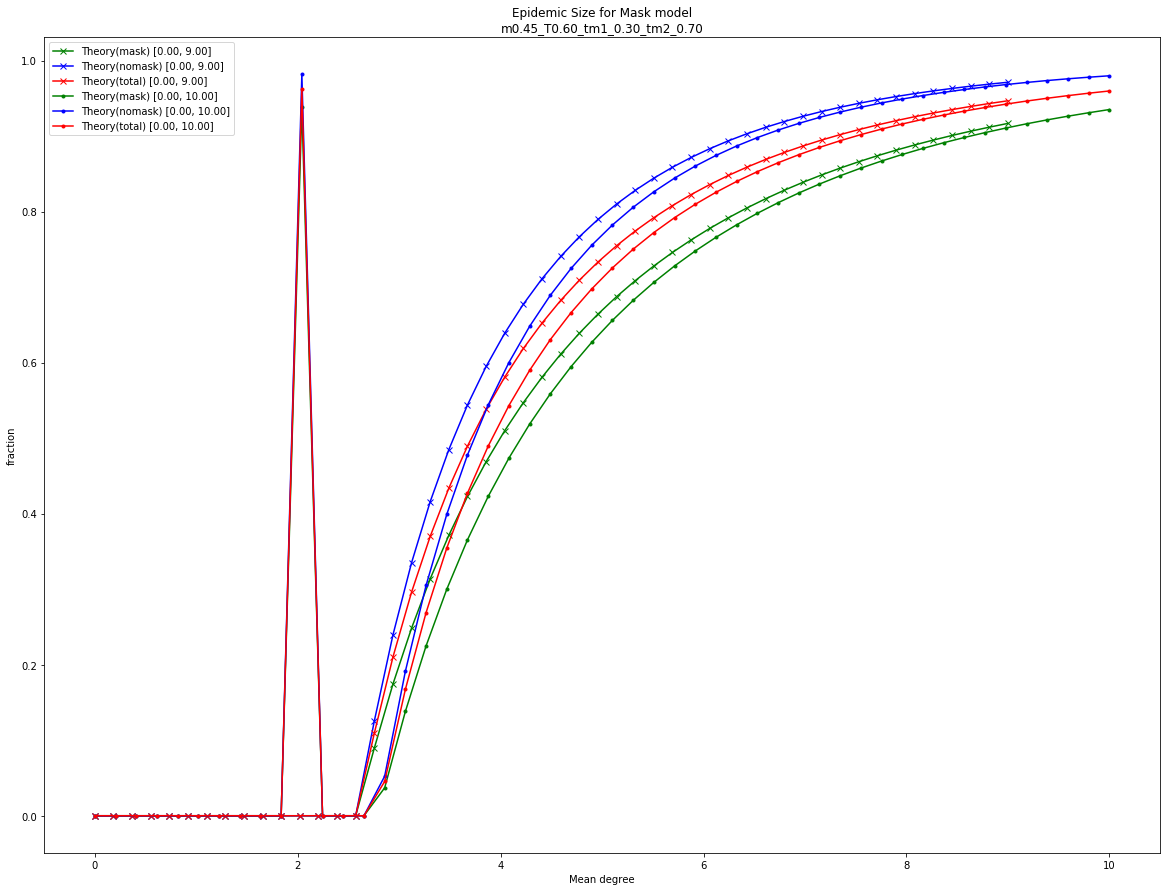

In [6]:
fig, ax = plt.subplots(figsize=(20,15))
legend_list = []
plot_anaylsis(es_0to9, ax, legend_list, 'x-')
plot_anaylsis(es_0to10, ax, legend_list, '.-')
title = "Epidemic Size for Mask model\nm%.2f_T%.2f_tm1_%.2f_tm2_%.2f" %(0.45, 0.6, 0.3, 0.7)  

set_ax(legend_list, 'Mean degree', 'fraction', title, ax)

# Check pe's single point with [0, 9] and [0, 10] 

In [7]:
pe_11 = load_analysis_results(m=0.45, 
                                T=0.6, 
                                tm1=0.3, 
                                tm2=0.7, 
                                itemname='pe', 
                                msg='single_point',
                                time_analysis='101916:29')

pe_10 = load_analysis_results(m=0.45, 
                                T=0.6, 
                                tm1=0.3, 
                                tm2=0.7, 
                                itemname='pe', 
                                msg='single_point',
                                time_analysis='101916:28')


pe_9p79 = load_analysis_results(m=0.45, 
                                T=0.6, 
                                tm1=0.3, 
                                tm2=0.7, 
                                itemname='pe', 
                                msg='single_point',
                                time_analysis='101916:27')



pe_3p06 = load_analysis_results(m=0.45, 
                                T=0.6, 
                                tm1=0.3, 
                                tm2=0.7, 
                                itemname='pe', 
                                msg='single_point',
                                time_analysis='')


pe_0to10 = load_analysis_results(m=0.45, 
                                T=0.6, 
                                tm1=0.3, 
                                tm2=0.7, 
                                itemname='pe', 
                                msg='test')

pe_0to9 = load_analysis_results(m=0.45, 
                                T=0.6, 
                                tm1=0.3, 
                                tm2=0.7, 
                                itemname='pe', 
                                msg='0to9')


m: 0.45
T: 0.6
tm1: 0.3
tm2: 0.7
msg: single_point
modelname: mask
itemname: pe
change: 0
n: 50
e: 10
cp: 5
time_analysis:  101916:29
Analysis path: /mnt/hdd-storage/ytian/ns/analysis/mask/pe/change_m/single_point/m0.45_T0.60_tm1_0.30_tm2_0.70/101916:29
m: 0.45
T: 0.6
tm1: 0.3
tm2: 0.7
msg: single_point
modelname: mask
itemname: pe
change: 0
n: 50
e: 10
cp: 5
time_analysis:  101916:28
Analysis path: /mnt/hdd-storage/ytian/ns/analysis/mask/pe/change_m/single_point/m0.45_T0.60_tm1_0.30_tm2_0.70/101916:28
m: 0.45
T: 0.6
tm1: 0.3
tm2: 0.7
msg: single_point
modelname: mask
itemname: pe
change: 0
n: 50
e: 10
cp: 5
time_analysis:  101916:27
Analysis path: /mnt/hdd-storage/ytian/ns/analysis/mask/pe/change_m/single_point/m0.45_T0.60_tm1_0.30_tm2_0.70/101916:27
m: 0.45
T: 0.6
tm1: 0.3
tm2: 0.7
msg: single_point
modelname: mask
itemname: pe
change: 0
n: 50
e: 10
cp: 5
time_analysis:  
101916:29
Analysis path: /mnt/hdd-storage/ytian/ns/analysis/mask/pe/change_m/single_point/m0.45_T0.60_tm1_0.30_tm

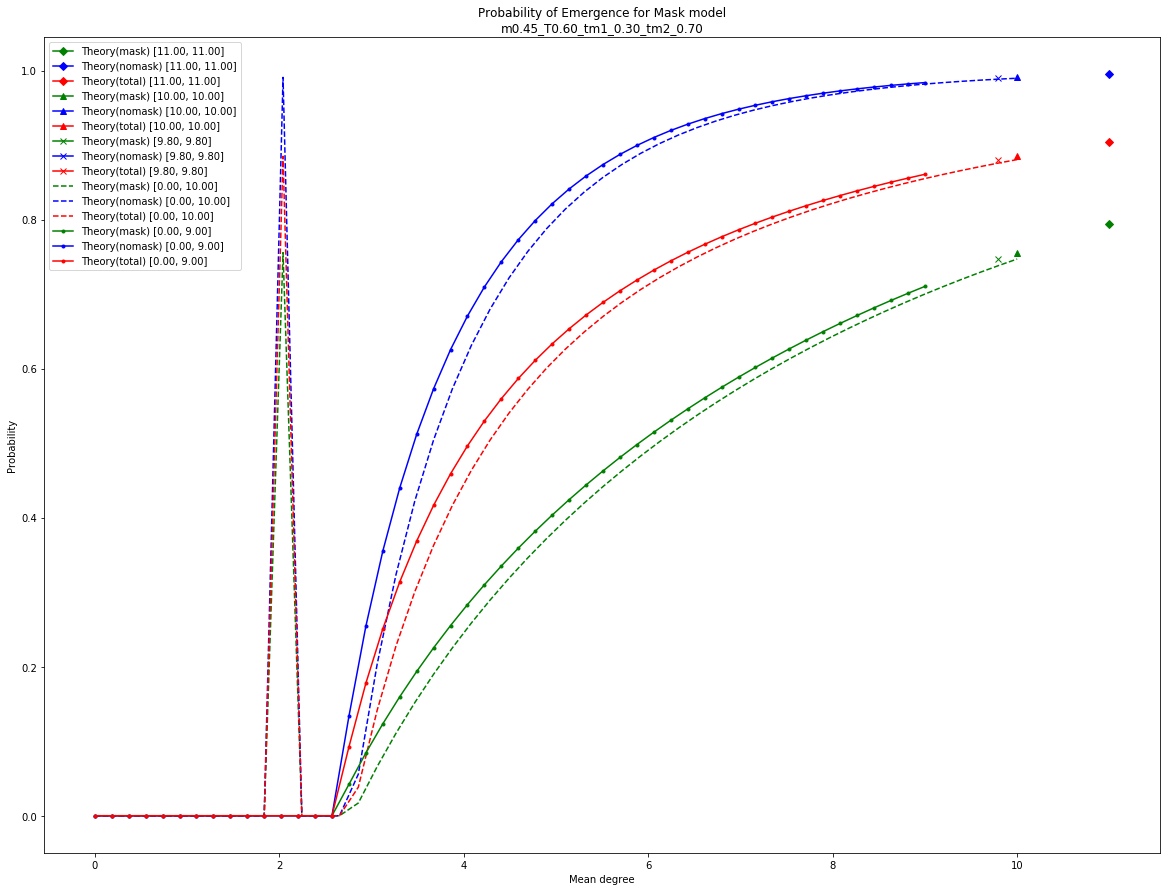

In [8]:
fig, ax = plt.subplots(figsize=(20,15))
legend_list = []

plot_anaylsis(pe_11, ax, legend_list, 'D-')
plot_anaylsis(pe_10, ax, legend_list, '^-')
plot_anaylsis(pe_9p79, ax, legend_list, 'x-')

# plot_anaylsis(res_9, ax, legend_list, 'x-')


plot_anaylsis(pe_0to10, ax, legend_list, '--')
plot_anaylsis(pe_0to9, ax, legend_list, '.-')

title = "Probability of Emergence for Mask model\nm%.2f_T%.2f_tm1_%.2f_tm2_%.2f" %(0.45, 0.6, 0.3, 0.7)  

set_ax(legend_list, 'Mean degree', 'Probability', title, ax)

# Check pe's 0to3 to 0to9 v.s. 0to10 

In [9]:
mask_list_0to3, paras_0to3, mdl_0to3 = get_processed_res(thr=0.05, n=5000, e=1000, 
                         m=0.45, T=0.6, 
                         tm1=0.3, tm2=0.7, 
                         checkpoint=100, 
                         msg='0to3', modelname='mask')

mask_list_0to5, paras_0to5, mdl_0to5 = get_processed_res(thr=0.05, n=5000, e=1000, 
                         m=0.45, T=0.6, 
                         tm1=0.3, tm2=0.7, 
                         checkpoint=100, 
                         msg='0to5', modelname='mask')

mask_list_0to7, paras_0to7, mdl_0to7 = get_processed_res(thr=0.05, n=5000, e=1000, 
                         m=0.45, T=0.6, 
                         tm1=0.3, tm2=0.7, 
                         checkpoint=100, 
                         msg='0to7', modelname='mask')
mask_list_0to9, paras_0to9, mdl_0to9 = get_processed_res(thr=0.05, n=5000, e=1000, 
                         m=0.45, T=0.6, 
                         tm1=0.3, tm2=0.7, 
                         checkpoint=100, 
                         msg='0to9', modelname='mask')

mask_list_0to10, paras_0to10, mdl_0to10 = get_processed_res(thr=0.05, n=50000, e=1000, 
                         m=0.45, T=0.6, 
                         tm1=0.3, tm2=0.7, 
                         checkpoint=100, 
                         msg='test', modelname='mask')

mask_list_2p6to3, paras_2p6to3, mdl_2p6to3 = get_processed_res(thr=0.05, n=5000, e=1000, 
                         m=0.45, T=0.6, 
                         tm1=0.3, tm2=0.7, 
                         checkpoint=100, 
                         msg='test',
                         time_exp='101222:58',
                        modelname='mask')

m: 0.45
T: 0.6
tm1: 0.3
tm2: 0.7
msg: 0to3
modelname: mask
itemname: es
change: 0
n: 5000
e: 1000
cp: 100
time_exp:  
101223:56
cp: 1
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101223:56/ss1/meandegree0.18367346938775508/cp1
cp: 2
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101223:56/ss1/meandegree0.18367346938775508/cp2
cp: 3
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101223:56/ss1/meandegree0.18367346938775508/cp3
cp: 4
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101223:56/ss1/meandegree0.18367346938775508/cp4
cp: 5
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101223:56/ss1/meandegree0.18367346938775508/c

cp: 1
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101223:56/ss1/meandegree0.7959183673469388/cp1
cp: 2
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101223:56/ss1/meandegree0.7959183673469388/cp2
cp: 3
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101223:56/ss1/meandegree0.7959183673469388/cp3
cp: 4
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101223:56/ss1/meandegree0.7959183673469388/cp4
cp: 5
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101223:56/ss1/meandegree0.7959183673469388/cp5
cp: 6
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101

cp: 5
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101223:56/ss2/meandegree2.020408163265306/cp5
cp: 6
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101223:56/ss2/meandegree2.020408163265306/cp6
cp: 7
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101223:56/ss2/meandegree2.020408163265306/cp7
cp: 8
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101223:56/ss2/meandegree2.020408163265306/cp8
cp: 9
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101223:56/ss2/meandegree2.020408163265306/cp9
cp: 10
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101223:

m: 0.45
T: 0.6
tm1: 0.3
tm2: 0.7
msg: 0to5
modelname: mask
itemname: es
change: 0
n: 5000
e: 1000
cp: 100
time_exp:  
101223:59
cp: 1
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101223:59/ss1/meandegree0.30612244897959184/cp1
cp: 2
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101223:59/ss1/meandegree0.30612244897959184/cp2
cp: 3
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101223:59/ss1/meandegree0.30612244897959184/cp3
cp: 4
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101223:59/ss1/meandegree0.30612244897959184/cp4
cp: 5
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101223:59/ss1/meandegree0.30612244897959184/c

cp: 7
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101223:59/ss1/meandegree2.0408163265306123/cp7
cp: 8
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101223:59/ss1/meandegree2.0408163265306123/cp8
cp: 9
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101223:59/ss1/meandegree2.0408163265306123/cp9
cp: 10
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101223:59/ss1/meandegree2.0408163265306123/cp10
cp: 1
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101223:59/ss1/meandegree2.7551020408163267/cp1
cp: 2
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/1

cp: 2
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101223:59/ss2/meandegree0.0/cp2
cp: 3
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101223:59/ss2/meandegree0.0/cp3
cp: 4
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101223:59/ss2/meandegree0.0/cp4
cp: 5
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101223:59/ss2/meandegree0.0/cp5
cp: 6
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101223:59/ss2/meandegree0.0/cp6
cp: 7
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101223:59/ss2/meandegree0.0/cp7
cp: 8
Experiment path: /mnt/hdd-storage/ytian/

cp: 3
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101223:59/ss2/meandegree3.5714285714285716/cp3
cp: 4
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101223:59/ss2/meandegree3.5714285714285716/cp4
cp: 5
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101223:59/ss2/meandegree3.5714285714285716/cp5
cp: 6
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101223:59/ss2/meandegree3.5714285714285716/cp6
cp: 7
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101223:59/ss2/meandegree3.5714285714285716/cp7
cp: 8
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101

cp: 5
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101300:03/ss1/meandegree0.2857142857142857/cp5
cp: 6
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101300:03/ss1/meandegree0.2857142857142857/cp6
cp: 7
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101300:03/ss1/meandegree0.2857142857142857/cp7
cp: 8
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101300:03/ss1/meandegree0.2857142857142857/cp8
cp: 9
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101300:03/ss1/meandegree0.2857142857142857/cp9
cp: 10
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/10

cp: 3
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101300:03/ss2/meandegree1.857142857142857/cp3
cp: 4
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101300:03/ss2/meandegree1.857142857142857/cp4
cp: 5
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101300:03/ss2/meandegree1.857142857142857/cp5
cp: 6
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101300:03/ss2/meandegree1.857142857142857/cp6
cp: 7
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101300:03/ss2/meandegree1.857142857142857/cp7
cp: 8
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101300:0

cp: 5
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101300:03/ss2/meandegree2.2857142857142856/cp5
cp: 6
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101300:03/ss2/meandegree2.2857142857142856/cp6
cp: 7
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101300:03/ss2/meandegree2.2857142857142856/cp7
cp: 8
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101300:03/ss2/meandegree2.2857142857142856/cp8
cp: 9
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101300:03/ss2/meandegree2.2857142857142856/cp9
cp: 10
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/10

cp: 1
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101300:07/ss1/meandegree0.5510204081632654/cp1
cp: 2
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101300:07/ss1/meandegree0.5510204081632654/cp2
cp: 3
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101300:07/ss1/meandegree0.5510204081632654/cp3
cp: 4
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101300:07/ss1/meandegree0.5510204081632654/cp4
cp: 5
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101300:07/ss1/meandegree0.5510204081632654/cp5
cp: 6
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101

cp: 10
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101300:07/ss1/meandegree4.591836734693878/cp10
cp: 1
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101300:07/ss1/meandegree3.673469387755102/cp1
cp: 2
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101300:07/ss1/meandegree3.673469387755102/cp2
cp: 3
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101300:07/ss1/meandegree3.673469387755102/cp3
cp: 4
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101300:07/ss1/meandegree3.673469387755102/cp4
cp: 5
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101300

cp: 8
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101300:07/ss2/meandegree0.9183673469387755/cp8
cp: 9
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101300:07/ss2/meandegree0.9183673469387755/cp9
cp: 10
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101300:07/ss2/meandegree0.9183673469387755/cp10
cp: 1
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101300:07/ss2/meandegree1.653061224489796/cp1
cp: 2
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101300:07/ss2/meandegree1.653061224489796/cp2
cp: 3
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101

m: 0.45
T: 0.6
tm1: 0.3
tm2: 0.7
msg: test
modelname: mask
itemname: es
change: 0
n: 50000
e: 1000
cp: 100
time_exp:  
101223:04
cp: 1
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/test/m0.45_T0.60_tm1_0.30_tm2_0.70/n50000_ttle1000/101223:04/ss1/meandegree3.0612244897959187/cp1
cp: 2
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/test/m0.45_T0.60_tm1_0.30_tm2_0.70/n50000_ttle1000/101223:04/ss1/meandegree3.0612244897959187/cp2
cp: 3
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/test/m0.45_T0.60_tm1_0.30_tm2_0.70/n50000_ttle1000/101223:04/ss1/meandegree3.0612244897959187/cp3
cp: 4
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/test/m0.45_T0.60_tm1_0.30_tm2_0.70/n50000_ttle1000/101223:04/ss1/meandegree3.0612244897959187/cp4
cp: 5
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/test/m0.45_T0.60_tm1_0.30_tm2_0.70/n50000_ttle1000/101223:04/ss1/meandegree3.0612244897959187/

cp: 9
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/test/m0.45_T0.60_tm1_0.30_tm2_0.70/n50000_ttle1000/101223:04/ss1/meandegree3.4693877551020407/cp9
cp: 10
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/test/m0.45_T0.60_tm1_0.30_tm2_0.70/n50000_ttle1000/101223:04/ss1/meandegree3.4693877551020407/cp10
cp: 1
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/test/m0.45_T0.60_tm1_0.30_tm2_0.70/n50000_ttle1000/101223:04/ss1/meandegree10.0/cp1
cp: 2
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/test/m0.45_T0.60_tm1_0.30_tm2_0.70/n50000_ttle1000/101223:04/ss1/meandegree10.0/cp2
cp: 3
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/test/m0.45_T0.60_tm1_0.30_tm2_0.70/n50000_ttle1000/101223:04/ss1/meandegree10.0/cp3
cp: 4
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/test/m0.45_T0.60_tm1_0.30_tm2_0.70/n50000_ttle1000/101223:04/ss1/meandegree10.0/cp4
cp: 

cp: 3
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/test/m0.45_T0.60_tm1_0.30_tm2_0.70/n50000_ttle1000/101223:04/ss2/meandegree5.714285714285714/cp3
cp: 4
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/test/m0.45_T0.60_tm1_0.30_tm2_0.70/n50000_ttle1000/101223:04/ss2/meandegree5.714285714285714/cp4
cp: 5
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/test/m0.45_T0.60_tm1_0.30_tm2_0.70/n50000_ttle1000/101223:04/ss2/meandegree5.714285714285714/cp5
cp: 6
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/test/m0.45_T0.60_tm1_0.30_tm2_0.70/n50000_ttle1000/101223:04/ss2/meandegree5.714285714285714/cp6
cp: 7
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/test/m0.45_T0.60_tm1_0.30_tm2_0.70/n50000_ttle1000/101223:04/ss2/meandegree5.714285714285714/cp7
cp: 8
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/test/m0.45_T0.60_tm1_0.30_tm2_0.70/n50000_ttle1000/10

m: 0.45
T: 0.6
tm1: 0.3
tm2: 0.7
msg: test
modelname: mask
itemname: es
change: 0
n: 5000
e: 1000
cp: 100
time_exp:  
101222:58
cp: 1
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/test/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101222:58/ss1/meandegree2.84/cp1
cp: 2
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/test/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101222:58/ss1/meandegree2.84/cp2
cp: 3
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/test/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101222:58/ss1/meandegree2.84/cp3
cp: 4
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/test/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101222:58/ss1/meandegree2.84/cp4
cp: 5
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/change_m/test/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle1000/101222:58/ss1/meandegree2.84/cp5
cp: 6
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/mask/es/chan

In [10]:
res_0to10 = load_analysis_results(m=0.45, 
                                T=0.6, 
                                tm1=0.3, 
                                tm2=0.7, 
                                itemname='pe', 
                                msg='test')
res_0to3 = load_analysis_results(m=0.45, 
                                T=0.6, 
                                tm1=0.3, 
                                tm2=0.7, 
                                itemname='pe', 
                                msg='0to3')
res_0to5 = load_analysis_results(m=0.45, 
                                T=0.6, 
                                tm1=0.3, 
                                tm2=0.7, 
                                itemname='pe', 
                                msg='0to5')
res_0to7 = load_analysis_results(m=0.45, 
                                T=0.6, 
                                tm1=0.3, 
                                tm2=0.7, 
                                itemname='pe', 
                                msg='0to7')
res_0to9 = load_analysis_results(m=0.45, 
                                T=0.6, 
                                tm1=0.3, 
                                tm2=0.7, 
                                itemname='pe', 
                                msg='0to9')
res_2p6to3 = load_analysis_results(m=0.45, 
                                T=0.6, 
                                tm1=0.3, 
                                tm2=0.7, 
                                itemname='pe', 
                                msg='test',
                                time_analysis='101221:03')

m: 0.45
T: 0.6
tm1: 0.3
tm2: 0.7
msg: test
modelname: mask
itemname: pe
change: 0
n: 50
e: 10
cp: 5
time_analysis:  
101222:54
Analysis path: /mnt/hdd-storage/ytian/ns/analysis/mask/pe/change_m/test/m0.45_T0.60_tm1_0.30_tm2_0.70/101222:54
m: 0.45
T: 0.6
tm1: 0.3
tm2: 0.7
msg: 0to3
modelname: mask
itemname: pe
change: 0
n: 50
e: 10
cp: 5
time_analysis:  
101300:05
Analysis path: /mnt/hdd-storage/ytian/ns/analysis/mask/pe/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/101300:05
m: 0.45
T: 0.6
tm1: 0.3
tm2: 0.7
msg: 0to5
modelname: mask
itemname: pe
change: 0
n: 50
e: 10
cp: 5
time_analysis:  
101300:13
Analysis path: /mnt/hdd-storage/ytian/ns/analysis/mask/pe/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/101300:13
m: 0.45
T: 0.6
tm1: 0.3
tm2: 0.7
msg: 0to7
modelname: mask
itemname: pe
change: 0
n: 50
e: 10
cp: 5
time_analysis:  
101300:19
Analysis path: /mnt/hdd-storage/ytian/ns/analysis/mask/pe/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/101300:19
m: 0.45
T: 0.6
tm1: 0.3
tm2: 0.7
msg: 0to9
m

NameError: name 'ani_list_0to3' is not defined

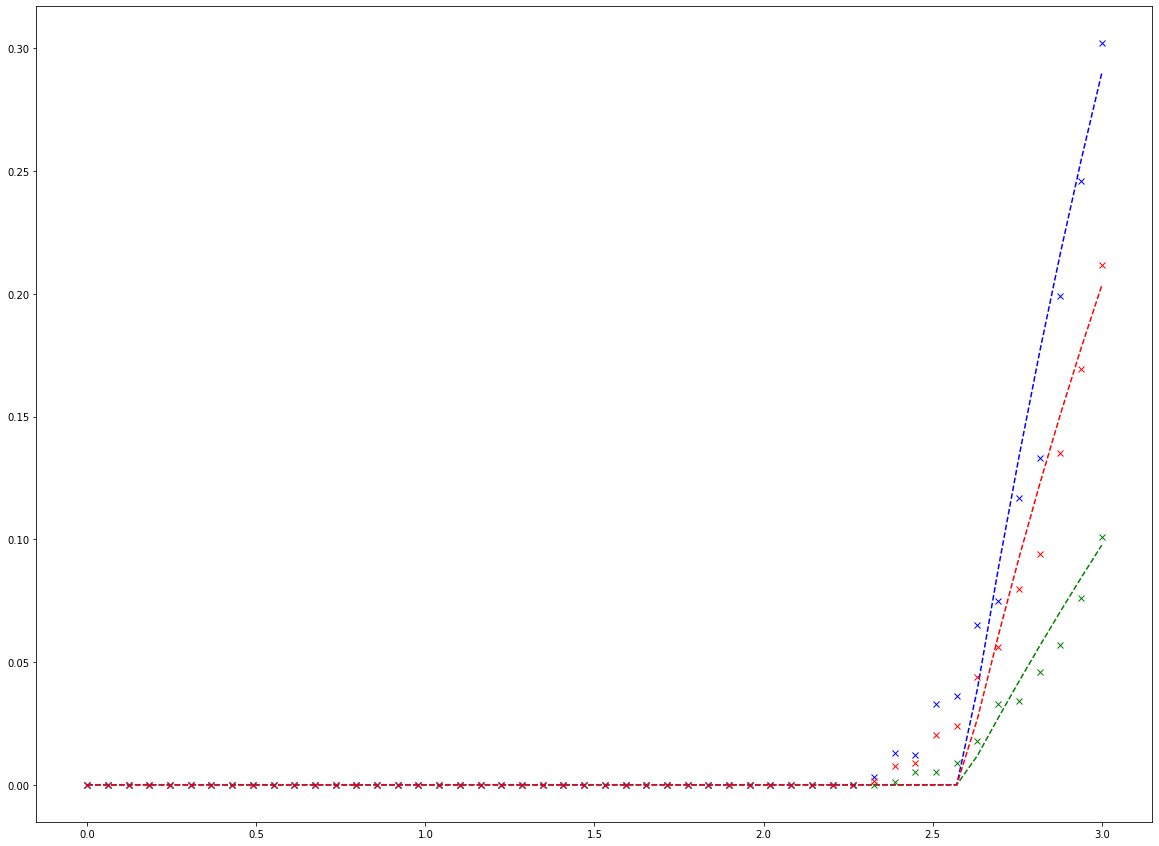

In [11]:
fig, ax = plt.subplots(figsize=(20,15))
legend_list = []

plot_anaylsis(res_0to3, ax, legend_list, '--')
plot_sim(mask_list_0to3, paras_0to3, mdl_0to3, ax, legend_list, 'x')
plot_sim(ani_list_0to3, paras_0to3, mdl_0to3, ax, legend_list, 'o')

# plot_anaylsis(res_0to5, ax, legend_list, '--')
# plot_sim(mask_list_0to5, paras_0to5, mdl_0to5, ax, legend_list, 'o')

# plot_anaylsis(res_0to7, ax, legend_list, '--')
# plot_sim(mask_list_0to7, paras_0to7, mdl_0to7, ax, legend_list, 'o')

# plot_anaylsis(res_0to9, ax, legend_list, '--')
# plot_sim(mask_list_0to9, paras_0to9, mdl_0to9, ax, legend_list, 'o')

# plot_anaylsis(res_2p6to3, ax, legend_list, '--')
# plot_sim(mask_list_2p6to3, paras_2p6to3, mdl_2p6to3, ax, legend_list, 'd')

# plot_anaylsis(res_0to10, ax, legend_list, 'P-')
# plot_sim(res_list_0to10, paras_0to10, mdl_0to10, ax, legend_list, 'P')


title = "Probability of Emergence for Mask model\nYurun simulation v.s. Ani simulation\nm%.2f_T%.2f_tm1_%.2f_tm2_%.2f" %(0.45, 0.6, 0.3, 0.7)  

set_ax(legend_list, 'Mean degree', 'Probability', title, ax)

# See if Ani's simulation's results also like this

In [12]:
res_0to10 = load_analysis_results(m=0.45, 
                                T=0.6, 
                                tm1=0.3, 
                                tm2=0.7, 
                                itemname='pe', 
                                msg='test')
res_0to3 = load_analysis_results(m=0.45, 
                                T=0.6, 
                                tm1=0.3, 
                                tm2=0.7, 
                                itemname='pe', 
                                msg='0to3')
res_0to5 = load_analysis_results(m=0.45, 
                                T=0.6, 
                                tm1=0.3, 
                                tm2=0.7, 
                                itemname='pe', 
                                msg='0to5')
res_0to7 = load_analysis_results(m=0.45, 
                                T=0.6, 
                                tm1=0.3, 
                                tm2=0.7, 
                                itemname='pe', 
                                msg='0to7')
res_0to9 = load_analysis_results(m=0.45, 
                                T=0.6, 
                                tm1=0.3, 
                                tm2=0.7, 
                                itemname='pe', 
                                msg='0to9')
res_2p6to3 = load_analysis_results(m=0.45, 
                                T=0.6, 
                                tm1=0.3, 
                                tm2=0.7, 
                                itemname='pe', 
                                msg='test',
                                time_analysis='101221:03')

m: 0.45
T: 0.6
tm1: 0.3
tm2: 0.7
msg: test
modelname: mask
itemname: pe
change: 0
n: 50
e: 10
cp: 5
time_analysis:  
101222:54
Analysis path: /mnt/hdd-storage/ytian/ns/analysis/mask/pe/change_m/test/m0.45_T0.60_tm1_0.30_tm2_0.70/101222:54
m: 0.45
T: 0.6
tm1: 0.3
tm2: 0.7
msg: 0to3
modelname: mask
itemname: pe
change: 0
n: 50
e: 10
cp: 5
time_analysis:  
101300:05
Analysis path: /mnt/hdd-storage/ytian/ns/analysis/mask/pe/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/101300:05
m: 0.45
T: 0.6
tm1: 0.3
tm2: 0.7
msg: 0to5
modelname: mask
itemname: pe
change: 0
n: 50
e: 10
cp: 5
time_analysis:  
101300:13
Analysis path: /mnt/hdd-storage/ytian/ns/analysis/mask/pe/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/101300:13
m: 0.45
T: 0.6
tm1: 0.3
tm2: 0.7
msg: 0to7
modelname: mask
itemname: pe
change: 0
n: 50
e: 10
cp: 5
time_analysis:  
101300:19
Analysis path: /mnt/hdd-storage/ytian/ns/analysis/mask/pe/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/101300:19
m: 0.45
T: 0.6
tm1: 0.3
tm2: 0.7
msg: 0to9
m

In [26]:
thr = 0.05
ani_list_0to3, paras_0to3, mdl_0to3 = get_processed_res(thr=thr, n=5000, e=10000, 
                         m=0.45, T=0.6, 
                         tm1=0.3, tm2=0.7, 
                         checkpoint=1000, 
                         msg='0to3', modelname='ani-mask')

ani_list_0to5, paras_0to5, mdl_0to5 = get_processed_res(thr=thr, n=5000, e=10000, 
                         m=0.45, T=0.6, 
                         tm1=0.3, tm2=0.7, 
                         checkpoint=1000, 
                         msg='0to5', modelname='ani-mask')

ani_list_0to7, paras_0to7, mdl_0to7 = get_processed_res(thr=thr, n=5000, e=10000, 
                         m=0.45, T=0.6, 
                         tm1=0.3, tm2=0.7, 
                         checkpoint=1000, 
                         msg='0to7', modelname='ani-mask')
ani_list_0to9, paras_0to9, mdl_0to9 = get_processed_res(thr=thr, n=5000, e=10000, 
                         m=0.45, T=0.6, 
                         tm1=0.3, tm2=0.7, 
                         checkpoint=1000, 
                         msg='0to9', modelname='ani-mask', 
                         time_exp='101918:33')

ani_list_0to10, paras_0to10, mdl_0to10 = get_processed_res(thr=thr, n=5000, e=10000, 
                         m=0.45, T=0.6, 
                         tm1=0.3, tm2=0.7, 
                         checkpoint=1000, 
                         msg='0to9', modelname='ani-mask', time_exp=
                                                          '101920:44')

m: 0.45
T: 0.6
tm1: 0.3
tm2: 0.7
msg: 0to3
modelname: ani-mask
itemname: es
change: 0
n: 5000
e: 10000
cp: 1000
time_exp:  
101919:11
cp: 1
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101919:11/ss1/meandegree0.18367346938775508/cp1
cp: 2
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101919:11/ss1/meandegree0.18367346938775508/cp2
cp: 3
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101919:11/ss1/meandegree0.18367346938775508/cp3
cp: 4
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101919:11/ss1/meandegree0.18367346938775508/cp4
cp: 5
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101919:11/ss1/

cp: 10
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101919:11/ss1/meandegree0.7346938775510203/cp10
cp: 1
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101919:11/ss1/meandegree1.836734693877551/cp1
cp: 2
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101919:11/ss1/meandegree1.836734693877551/cp2
cp: 3
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101919:11/ss1/meandegree1.836734693877551/cp3
cp: 4
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101919:11/ss1/meandegree1.836734693877551/cp4
cp: 5
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_

Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101919:11/ss1/meandegree0.6122448979591837/cp2
cp: 3
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101919:11/ss1/meandegree0.6122448979591837/cp3
cp: 4
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101919:11/ss1/meandegree0.6122448979591837/cp4
cp: 5
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101919:11/ss1/meandegree0.6122448979591837/cp5
cp: 6
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101919:11/ss1/meandegree0.6122448979591837/cp6
cp: 7
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_

cp: 5
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101919:11/ss1/meandegree0.673469387755102/cp5
cp: 6
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101919:11/ss1/meandegree0.673469387755102/cp6
cp: 7
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101919:11/ss1/meandegree0.673469387755102/cp7
cp: 8
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101919:11/ss1/meandegree0.673469387755102/cp8
cp: 9
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101919:11/ss1/meandegree0.673469387755102/cp9
cp: 10
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm

cp: 3
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101919:11/ss1/meandegree0.9183673469387755/cp3
cp: 4
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101919:11/ss1/meandegree0.9183673469387755/cp4
cp: 5
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101919:11/ss1/meandegree0.9183673469387755/cp5
cp: 6
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101919:11/ss1/meandegree0.9183673469387755/cp6
cp: 7
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101919:11/ss1/meandegree0.9183673469387755/cp7
cp: 8
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to3/m0.45_T0.60_tm1_0.3

cp: 2
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101919:11/ss1/meandegree2.0816326530612246/cp2
cp: 3
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101919:11/ss1/meandegree2.0816326530612246/cp3
cp: 4
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101919:11/ss1/meandegree2.0816326530612246/cp4
cp: 5
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101919:11/ss1/meandegree2.0816326530612246/cp5
cp: 6
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101919:11/ss1/meandegree2.0816326530612246/cp6
cp: 7
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to3/m0.45_T0.60_tm1_0.3

cp: 1
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101919:11/ss2/meandegree1.530612244897959/cp1
cp: 2
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101919:11/ss2/meandegree1.530612244897959/cp2
cp: 3
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101919:11/ss2/meandegree1.530612244897959/cp3
cp: 4
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101919:11/ss2/meandegree1.530612244897959/cp4
cp: 5
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101919:11/ss2/meandegree1.530612244897959/cp5
cp: 6
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2

cp: 8
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101919:11/ss2/meandegree0.673469387755102/cp8
cp: 9
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101919:11/ss2/meandegree0.673469387755102/cp9
cp: 10
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101919:11/ss2/meandegree0.673469387755102/cp10
cp: 1
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101919:11/ss2/meandegree2.204081632653061/cp1
cp: 2
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101919:11/ss2/meandegree2.204081632653061/cp2
cp: 3
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_t

cp: 10
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101919:11/ss2/meandegree2.510204081632653/cp10
cp: 1
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101919:11/ss2/meandegree2.0816326530612246/cp1
cp: 2
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101919:11/ss2/meandegree2.0816326530612246/cp2
cp: 3
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101919:11/ss2/meandegree2.0816326530612246/cp3
cp: 4
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to3/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101919:11/ss2/meandegree2.0816326530612246/cp4
cp: 5
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to3/m0.45_T0.60_tm1_0.

m: 0.45
T: 0.6
tm1: 0.3
tm2: 0.7
msg: 0to5
modelname: ani-mask
itemname: es
change: 0
n: 5000
e: 10000
cp: 1000
time_exp:  
101918:49
cp: 1
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:49/ss1/meandegree0.30612244897959184/cp1
cp: 2
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:49/ss1/meandegree0.30612244897959184/cp2
cp: 3
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:49/ss1/meandegree0.30612244897959184/cp3
cp: 4
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:49/ss1/meandegree0.30612244897959184/cp4
cp: 5
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:49/ss1/

cp: 9
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:49/ss1/meandegree0.5102040816326531/cp9
cp: 10
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:49/ss1/meandegree0.5102040816326531/cp10
cp: 1
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:49/ss1/meandegree0.0/cp1
cp: 2
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:49/ss1/meandegree0.0/cp2
cp: 3
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:49/ss1/meandegree0.0/cp3
cp: 4
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:49/ss1/me

cp: 6
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:49/ss1/meandegree1.1224489795918369/cp6
cp: 7
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:49/ss1/meandegree1.1224489795918369/cp7
cp: 8
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:49/ss1/meandegree1.1224489795918369/cp8
cp: 9
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:49/ss1/meandegree1.1224489795918369/cp9
cp: 10
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:49/ss1/meandegree1.1224489795918369/cp10
cp: 1
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to5/m0.45_T0.60_tm1_0

cp: 5
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:49/ss1/meandegree3.979591836734694/cp5
cp: 6
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:49/ss1/meandegree3.979591836734694/cp6
cp: 7
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:49/ss1/meandegree3.979591836734694/cp7
cp: 8
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:49/ss1/meandegree3.979591836734694/cp8
cp: 9
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:49/ss1/meandegree3.979591836734694/cp9
cp: 10
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm

cp: 6
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:49/ss1/meandegree4.795918367346939/cp6
cp: 7
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:49/ss1/meandegree4.795918367346939/cp7
cp: 8
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:49/ss1/meandegree4.795918367346939/cp8
cp: 9
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:49/ss1/meandegree4.795918367346939/cp9
cp: 10
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:49/ss1/meandegree4.795918367346939/cp10
cp: 1
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_t

cp: 10
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:49/ss2/meandegree1.9387755102040818/cp10
cp: 1
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:49/ss2/meandegree0.40816326530612246/cp1
cp: 2
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:49/ss2/meandegree0.40816326530612246/cp2
cp: 3
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:49/ss2/meandegree0.40816326530612246/cp3
cp: 4
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:49/ss2/meandegree0.40816326530612246/cp4
cp: 5
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to5/m0.45_T0.60_t

cp: 9
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:49/ss2/meandegree4.4897959183673475/cp9
cp: 10
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:49/ss2/meandegree4.4897959183673475/cp10
cp: 1
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:49/ss2/meandegree1.0204081632653061/cp1
cp: 2
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:49/ss2/meandegree1.0204081632653061/cp2
cp: 3
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:49/ss2/meandegree1.0204081632653061/cp3
cp: 4
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to5/m0.45_T0.60_tm1_0

cp: 1
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:49/ss2/meandegree4.795918367346939/cp1
cp: 2
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:49/ss2/meandegree4.795918367346939/cp2
cp: 3
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:49/ss2/meandegree4.795918367346939/cp3
cp: 4
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:49/ss2/meandegree4.795918367346939/cp4
cp: 5
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:49/ss2/meandegree4.795918367346939/cp5
cp: 6
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to5/m0.45_T0.60_tm1_0.30_tm2

m: 0.45
T: 0.6
tm1: 0.3
tm2: 0.7
msg: 0to7
modelname: ani-mask
itemname: es
change: 0
n: 5000
e: 10000
cp: 1000
time_exp:  
101918:58
cp: 1
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:58/ss1/meandegree1.7142857142857142/cp1
cp: 2
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:58/ss1/meandegree1.7142857142857142/cp2
cp: 3
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:58/ss1/meandegree1.7142857142857142/cp3
cp: 4
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:58/ss1/meandegree1.7142857142857142/cp4
cp: 5
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:58/ss1/mean

cp: 4
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:58/ss1/meandegree5.0/cp4
cp: 5
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:58/ss1/meandegree5.0/cp5
cp: 6
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:58/ss1/meandegree5.0/cp6
cp: 7
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:58/ss1/meandegree5.0/cp7
cp: 8
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:58/ss1/meandegree5.0/cp8
cp: 9
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:58/ss1/meandegree5.0/cp9
cp: 10
Experimen

cp: 9
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:58/ss1/meandegree5.857142857142857/cp9
cp: 10
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:58/ss1/meandegree5.857142857142857/cp10
cp: 1
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:58/ss1/meandegree0.14285714285714285/cp1
cp: 2
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:58/ss1/meandegree0.14285714285714285/cp2
cp: 3
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:58/ss1/meandegree0.14285714285714285/cp3
cp: 4
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to7/m0.45_T0.60_tm1_

cp: 8
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:58/ss1/meandegree4.0/cp8
cp: 9
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:58/ss1/meandegree4.0/cp9
cp: 10
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:58/ss1/meandegree4.0/cp10
cp: 1
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:58/ss1/meandegree2.142857142857143/cp1
cp: 2
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:58/ss1/meandegree2.142857142857143/cp2
cp: 3
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:58/ss1/mean

cp: 9
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:58/ss1/meandegree2.2857142857142856/cp9
cp: 10
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:58/ss1/meandegree2.2857142857142856/cp10
cp: 1
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:58/ss1/meandegree0.42857142857142855/cp1
cp: 2
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:58/ss1/meandegree0.42857142857142855/cp2
cp: 3
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:58/ss1/meandegree0.42857142857142855/cp3
cp: 4
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to7/m0.45_T0.60_tm

cp: 1
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:58/ss1/meandegree1.2857142857142856/cp1
cp: 2
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:58/ss1/meandegree1.2857142857142856/cp2
cp: 3
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:58/ss1/meandegree1.2857142857142856/cp3
cp: 4
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:58/ss1/meandegree1.2857142857142856/cp4
cp: 5
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:58/ss1/meandegree1.2857142857142856/cp5
cp: 6
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to7/m0.45_T0.60_tm1_0.3

cp: 7
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:58/ss2/meandegree4.714285714285714/cp7
cp: 8
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:58/ss2/meandegree4.714285714285714/cp8
cp: 9
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:58/ss2/meandegree4.714285714285714/cp9
cp: 10
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:58/ss2/meandegree4.714285714285714/cp10
cp: 1
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:58/ss2/meandegree3.0/cp1
cp: 2
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_

cp: 1
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:58/ss2/meandegree2.142857142857143/cp1
cp: 2
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:58/ss2/meandegree2.142857142857143/cp2
cp: 3
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:58/ss2/meandegree2.142857142857143/cp3
cp: 4
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:58/ss2/meandegree2.142857142857143/cp4
cp: 5
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:58/ss2/meandegree2.142857142857143/cp5
cp: 6
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to7/m0.45_T0.60_tm1_0.30_tm2

m: 0.45
T: 0.6
tm1: 0.3
tm2: 0.7
msg: 0to9
modelname: ani-mask
itemname: es
change: 0
n: 5000
e: 10000
cp: 1000
time_exp:  101918:33
cp: 1
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:33/ss1/meandegree8.26530612244898/cp1
cp: 2
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:33/ss1/meandegree8.26530612244898/cp2
cp: 3
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:33/ss1/meandegree8.26530612244898/cp3
cp: 4
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:33/ss1/meandegree8.26530612244898/cp4
cp: 5
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:33/ss1/meandegree8.2

cp: 3
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:33/ss1/meandegree6.612244897959184/cp3
cp: 4
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:33/ss1/meandegree6.612244897959184/cp4
cp: 5
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:33/ss1/meandegree6.612244897959184/cp5
cp: 6
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:33/ss1/meandegree6.612244897959184/cp6
cp: 7
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:33/ss1/meandegree6.612244897959184/cp7
cp: 8
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2

cp: 7
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:33/ss1/meandegree8.816326530612246/cp7
cp: 8
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:33/ss1/meandegree8.816326530612246/cp8
cp: 9
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:33/ss1/meandegree8.816326530612246/cp9
cp: 10
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:33/ss1/meandegree8.816326530612246/cp10
cp: 1
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:33/ss1/meandegree7.8979591836734695/cp1
cp: 2
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_

cp: 8
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:33/ss1/meandegree7.530612244897959/cp8
cp: 9
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:33/ss1/meandegree7.530612244897959/cp9
cp: 10
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:33/ss1/meandegree7.530612244897959/cp10
cp: 1
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:33/ss1/meandegree6.428571428571429/cp1
cp: 2
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:33/ss1/meandegree6.428571428571429/cp2
cp: 3
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_t

cp: 6
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:33/ss1/meandegree8.63265306122449/cp6
cp: 7
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:33/ss1/meandegree8.63265306122449/cp7
cp: 8
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:33/ss1/meandegree8.63265306122449/cp8
cp: 9
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:33/ss1/meandegree8.63265306122449/cp9
cp: 10
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:33/ss1/meandegree8.63265306122449/cp10
cp: 1
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.

cp: 10
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:33/ss1/meandegree7.346938775510204/cp10
cp: 1
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:33/ss1/meandegree2.0204081632653064/cp1
cp: 2
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:33/ss1/meandegree2.0204081632653064/cp2
cp: 3
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:33/ss1/meandegree2.0204081632653064/cp3
cp: 4
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:33/ss1/meandegree2.0204081632653064/cp4
cp: 5
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to9/m0.45_T0.60_tm1_0.

cp: 3
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:33/ss2/meandegree3.489795918367347/cp3
cp: 4
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:33/ss2/meandegree3.489795918367347/cp4
cp: 5
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:33/ss2/meandegree3.489795918367347/cp5
cp: 6
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:33/ss2/meandegree3.489795918367347/cp6
cp: 7
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:33/ss2/meandegree3.489795918367347/cp7
cp: 8
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2

cp: 10
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:33/ss2/meandegree6.428571428571429/cp10
cp: 1
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:33/ss2/meandegree7.714285714285714/cp1
cp: 2
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:33/ss2/meandegree7.714285714285714/cp2
cp: 3
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:33/ss2/meandegree7.714285714285714/cp3
cp: 4
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:33/ss2/meandegree7.714285714285714/cp4
cp: 5
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_t

cp: 10
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:33/ss2/meandegree7.346938775510204/cp10
cp: 1
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:33/ss2/meandegree2.0204081632653064/cp1
cp: 2
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:33/ss2/meandegree2.0204081632653064/cp2
cp: 3
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:33/ss2/meandegree2.0204081632653064/cp3
cp: 4
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/n5000_ttle10000/101918:33/ss2/meandegree2.0204081632653064/cp4
cp: 5
Experiment path: /mnt/hdd-storage/ytian/ns/simulation/ani-mask/es/change_m/0to9/m0.45_T0.60_tm1_0.

In [30]:
mdl_0to10

array([ 0.        ,  0.20408163,  0.40816327,  0.6122449 ,  0.81632653,
        1.02040816,  1.2244898 ,  1.42857143,  1.63265306,  1.83673469,
        2.04081633,  2.24489796,  2.44897959,  2.65306122,  2.85714286,
        3.06122449,  3.26530612,  3.46938776,  3.67346939,  3.87755102,
        4.08163265,  4.28571429,  4.48979592,  4.69387755,  4.89795918,
        5.10204082,  5.30612245,  5.51020408,  5.71428571,  5.91836735,
        6.12244898,  6.32653061,  6.53061224,  6.73469388,  6.93877551,
        7.14285714,  7.34693878,  7.55102041,  7.75510204,  7.95918367,
        8.16326531,  8.36734694,  8.57142857,  8.7755102 ,  8.97959184,
        9.18367347,  9.3877551 ,  9.59183673,  9.79591837, 10.        ])

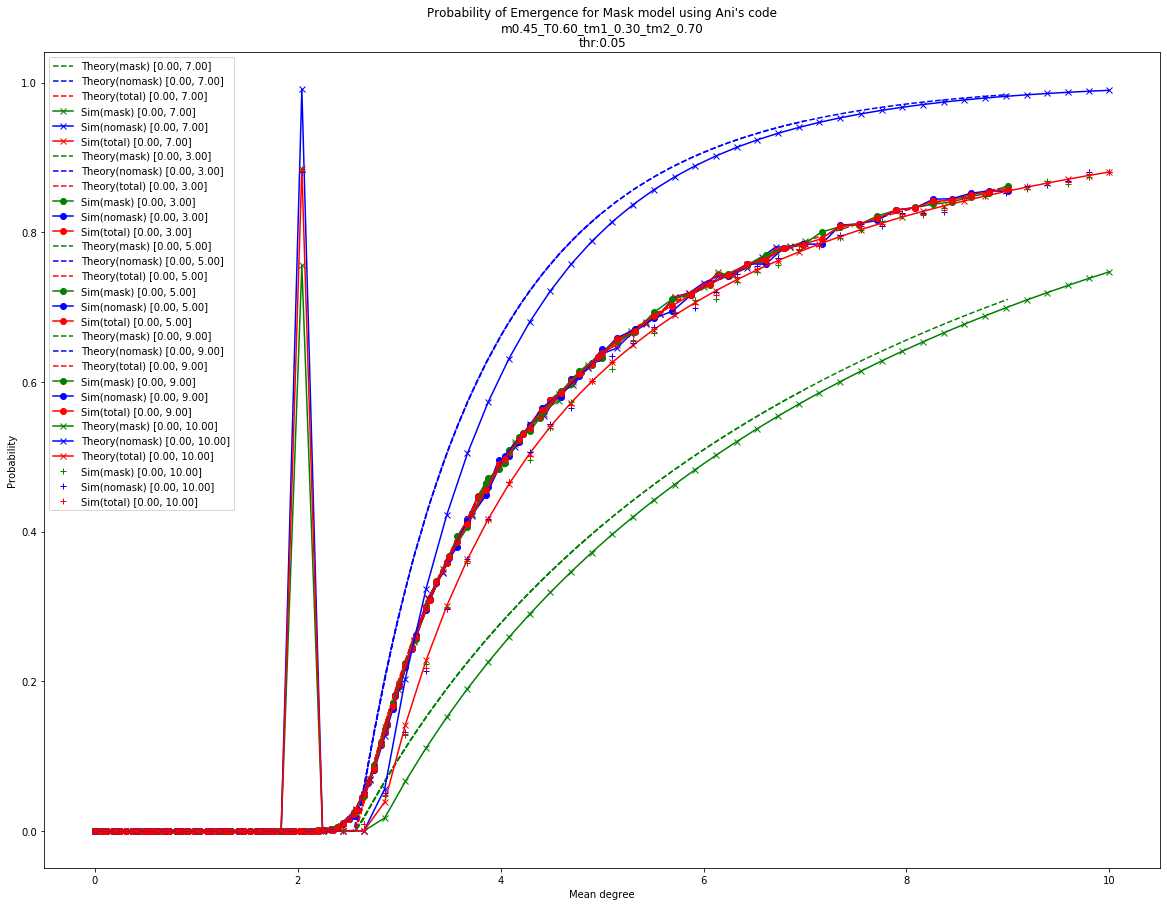

In [36]:
fig, ax = plt.subplots(figsize=(20,15))
legend_list = []



plot_anaylsis(res_0to7, ax, legend_list, '--')
plot_sim(ani_list_0to7, paras_0to7, mdl_0to7, ax, legend_list, 'x-')

plot_anaylsis(res_0to3, ax, legend_list, '--')
plot_sim(ani_list_0to3, paras_0to3, mdl_0to3, ax, legend_list, 'o-')

plot_anaylsis(res_0to5, ax, legend_list, '--')
plot_sim(ani_list_0to5, paras_0to5, mdl_0to5, ax, legend_list, 'o-')

plot_anaylsis(res_0to9, ax, legend_list, '--')
plot_sim(ani_list_0to9, paras_0to9, mdl_0to9, ax, legend_list, 'o-')

plot_anaylsis(res_0to10, ax, legend_list, 'x-')
plot_sim(ani_list_0to10, paras_0to10, mdl_0to10, ax, legend_list, '+')

# plot_anaylsis(res_0to10, ax, legend_list, '--')
# plot_sim(ani_list_0to10, paras_0to10, mdl_0to10, ax, legend_list, '+-')

# plot_anaylsis(res_0to9, ax, legend_list, '--')
# plot_sim(mask_list_0to3, paras_0to3, mdl_0to3, ax, legend_list, '.-')
# plot_sim(mask_list_0to5, paras_0to5, mdl_0to5, ax, legend_list, 'd')
# plot_sim(mask_list_0to7, paras_0to7, mdl_0to7, ax, legend_list, 'd')

# plot_anaylsis(res_0to3, ax, legend_list, '--')
# plot_sim(mask_list_0to3, paras_0to3, mdl_0to3, ax, legend_list, 'd-')

# plot_anaylsis(res_0to10, ax, legend_list, 'P-')
# plot_sim(res_list_0to10, paras_0to10, mdl_0to10, ax, legend_list, 'P')


title = "Probability of Emergence for Mask model using Ani's code\nm%.2f_T%.2f_tm1_%.2f_tm2_%.2f\nthr:%.2f" %(0.45, 0.6, 0.3, 0.7, thr)  

set_ax(legend_list, 'Mean degree', 'Probability', title, ax)

# Change m = [0.1, 0.9], mean_degree = 5

In [3]:
degree_min = 0
degree_max = 10 # para md in simulation script
interval_num = 50 # para ns in simulation script
mean_degree_list = np.linspace(degree_min, degree_max, interval_num)

In [4]:
load_dm5_change_ES(thrVal0=0.05, thrVal1=0.05, metric_analysis = 'tm', which_tm=2)



change tm=0.10
load_happyfeet_raw_results: m0.45_T0.60_tm1_0.30_tm2_0.10
092116:38
Data from ss1
load_happyfeet_raw_results: m0.45_T0.60_tm1_0.30_tm2_0.10
092116:38
Data from ss2
{'e': 100, 'n': 5000000, 'th': 0.01, 'tm1': 0.3, 'tm2': 0.1, 'm': 0.45, 'T': 0.6, 'md': 5, 'ns': 1, 'meandegree': 5.0, 'start_strain ': 2, 'check_point': 1}
pe [0.527]

Load analysis!
Model  Mask
change  tm
m0.45_T0.60_tm1_0.30_tm2_0.10
es_analysis/Mask_ES_Analysis_change_tm
092018:23
Model  Mask
change  tm
m0.45_T0.60_tm1_0.30_tm2_0.10
092820:35
Here: pe_analysis/Mask_PE_Analysis_change_tm/m0.45_T0.60_tm1_0.30_tm2_0.10/092820:35/Results/
mdlist from PE analysis: ['5.0']
Load analysis done!
[0.05078514]


IndexError: list index out of range

In [5]:
# load_dm5_change_m_ES(thrVal0 = 0.03, thrVal1 = 0.03)

# Plot ES theory v.s. simulation

In [107]:
'''Load  ES analysis results'''
print('Load ES analysis results')

# model_names = ['Mask', 'Mutation']
model_names = ['Mask',]
metric_analysis = 'm'
para_setting = 'm0.6_T0.70_tm1_0.40_tm2_0.60'

infection_size = load_ES_analysis_results(metric_analysis, para_setting, model_names, exp_time='092618:13')



infection_size['Mask'][metric_analysis][para_setting][0][10] = 0
infection_size['Mask'][metric_analysis][para_setting][1][10] = 0
infection_size['Mask'][metric_analysis][para_setting][2][10] = 0


# infection_size[model_names[1]][metric_analysis][para_setting][0][10] = 0
# infection_size[model_names[1]][metric_analysis][para_setting][1][10] = 0
# infection_size[model_names[1]][metric_analysis][para_setting][2][10] = 0

ES0 = np.array(infection_size['Mask'][metric_analysis][para_setting][0]) 
ES1 = np.array(infection_size['Mask'][metric_analysis][para_setting][1]) 
ES = ES1 + ES0



Load ES analysis results
Model  Mask
change  m
m0.6_T0.70_tm1_0.40_tm2_0.60
es_analysis/Mask_ES_Analysis_change_m


In [108]:
# '''Load  raw simulation results for ES(new path)'''

# sim_model_names = ['Mask2', ]
# base_happy_path = data_path + 'simulation/'
# sim_metric = 'm'
# exp_setting = 'n5000_totalexp1000'
# sim_model_name = sim_model_names[0]

# raw_ss1, paras = load_happyfeet_raw_results(base_happy_path, sim_metric, 
#                                     para_setting, 
#                                     exp_setting, 
#                                     sim_model_name, 
#                                     start_strain=0, )

# raw_ss2, paras = load_happyfeet_raw_results(base_happy_path, sim_metric, 
#                                     para_setting, 
#                                     exp_setting, 
#                                     sim_model_name, 
#                                     start_strain=1, )


# m = paras['m']
# T = paras['T']
# tm1 = paras['tm1']
# tm2 = paras['tm2']
# paras

In [109]:
'''
Play with threshold for ES using raw results
'''
degree_min = 0
degree_max = 10 # para md in simulation script
interval_num = 50 # para ns in simulation script
mean_degree_list = np.linspace(degree_min, degree_max, interval_num)

check_point = paras['e']
thrVal = 0.0001
es0_s1, es1_s1, es_s1, pe0, ml0 = resolve_rawdata(raw_ss1, check_point, thrVal)
# es0_s2, es1_s2, es_s2, pe1, ml1 = resolve_rawdata(raw_ss2, check_point, thrVal)

es0 = es0_s1
es1 = es1_s1 

es = es0 + es1

# print(ml0)
start = np.where(mean_degree_list == ml0[0])[0][0]
end   = np.where(mean_degree_list == ml0[-1])[0][0] + 1

mean_degree_list_plot = mean_degree_list[start: end]
ES0_plot = list(ES0)[start: end]
ES1_plot = list(ES1)[start: end]
ES_plot  = list(ES)[start: end]
# print(ml0)
# print(mean_degree_list_plot)

NameError: name 'paras' is not defined

NameError: name 'ES0_mu' is not defined

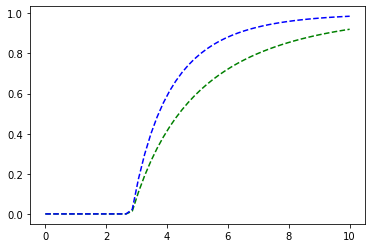

In [110]:
'''
Plot ES analysis v.s. simulation
'''

mean_degree_list_plot = mean_degree_list

# plt.plot(mean_degree_list_plot, ES0_plot, 'g--')
# plt.plot(mean_degree_list_plot, ES1_plot, 'b--')
# plt.plot(mean_degree_list_plot, ES_plot, 'r--')

plt.plot(mean_degree_list_plot, ES0, 'g--')
plt.plot(mean_degree_list_plot, ES1, 'b--')
# plt.plot(mean_degree_list_plot, ES, 'r--')

plt.plot(mean_degree_list_plot, ES0_mu, 'g.')
plt.plot(mean_degree_list_plot, ES1_mu, 'b.')
# plt.plot(mean_degree_list_plot, ES_mu, 'r.')


# plt.plot(mean_degree_list, infection_size[model_names[1]][metric_analysis][para_setting][0], 'g.')
# plt.plot(mean_degree_list, infection_size[model_names[1]][metric_analysis][para_setting][1], 'b.')
# plt.plot(mean_degree_list, np.array(infection_size[model_names[1]][metric_analysis][para_setting][0]) + np.array(infection_size[model_names[1]][metric_analysis][para_setting][1]), 'r.')


# plt.scatter(mean_degree_list_plot, np.array(es0), facecolors='none', edgecolors='g')
# plt.scatter(mean_degree_list_plot, np.array(es1), facecolors='none', edgecolors='b')
# plt.scatter(mean_degree_list_plot, np.array(es) , facecolors='none', edgecolors='r')

# plt.scatter(mean_degree_list, np.array(es0_) , 'g+')
# plt.plot(mean_degree_list, np.array(es1_) , 'b+')
# plt.plot(mean_degree_list, np.array(es_), 'r+')

# plt.plot(mean_degree_list, np.array(if0_sirius) , 'gx')
# plt.plot(mean_degree_list, np.array(if1_sirius) , 'bx')
# plt.plot(mean_degree_list, np.array(if0_sirius)  + np.array(if1_sirius), 'rx')

plt.legend([
#             "Mask theory(mask)", 
#             "Mask theory(no mask)",
#             "Mask theory(total)",
            "Theory(mask)", 
            "Theory(no mask)",
#             "Theory(total)",
    
            "Mutation theory(S1)", 
            "Mutation theory(S2)",
#             "Mutation theory(total)", 

#            "Mask simulation(mask)", 
#             "Mask simulation(no mask)",
#             "Mask simulation(total)",
#             "Simulation(mask)", 
#             "Simulation(no mask)",
#             "Simulation(total)",
],)

plt.xlabel("Mean degree")
plt.ylabel("Fraction")
print(para_setting)
title = "Epidemic Size\nMask model v.s. Mutation model"
plt.title(title)

# Mask PE theory v.s. PE simualtion

In [6]:
'''Load  PE analysis results'''
para_setting = 'm0.45_T0.60_tm1_0.30_tm2_0.70'
model_names = ['Mask',]
# '092618:13' # 0.6_0.7_0.4_0.6
# 091519:10 # m0.45_T0.60_tm1_0.30_tm2_0.70
metric_analysis = 'm'
prob_emergence = load_PE_analysis_results('m', para_setting, model_names, exp_time='091519:10')

prob_emergence[model_names[0]][metric_analysis][para_setting][0][10] = 0
prob_emergence[model_names[0]][metric_analysis][para_setting][1][10] = 0
prob_emergence[model_names[0]][metric_analysis][para_setting][2][10] = 0

# prob_emergence[model_names[1]][metric_analysis][para_setting][0][10] = 0
# prob_emergence[model_names[1]][metric_analysis][para_setting][1][10] = 0
# prob_emergence[model_names[1]][metric_analysis][para_setting][2][10] = 0

PE0 = np.array(prob_emergence[model_names[0]][metric_analysis][para_setting][0])
PE1 = np.array(prob_emergence[model_names[0]][metric_analysis][para_setting][1])



Model  Mask
change  m
m0.45_T0.60_tm1_0.30_tm2_0.70
091519:10
Here: ./analysis_scripts/pe_analysis/Mask_PE_Analysis_change_m/m0.45_T0.60_tm1_0.30_tm2_0.70/091519:10/Results/
mdlist from PE analysis: ['0.0', '0.20408163265306123', '0.40816326530612246', '0.6122448979591837', '0.8163265306122449', '1.0204081632653061', '1.2244897959183674', '1.4285714285714286', '1.6326530612244898', '1.836734693877551', '10.0', '2.0408163265306123', '2.2448979591836737', '2.4489795918367347', '2.6530612244897958', '2.857142857142857', '3.0612244897959187', '3.2653061224489797', '3.4693877551020407', '3.673469387755102', '3.8775510204081636', '4.081632653061225', '4.285714285714286', '4.4897959183673475', '4.6938775510204085', '4.8979591836734695', '5.1020408163265305', '5.3061224489795915', '5.510204081632653', '5.714285714285714', '5.918367346938775', '6.122448979591837', '6.326530612244898', '6.530612244897959', '6.73469387755102', '6.938775510204081', '7.142857142857143', '7.346938775510204', '7.5510

In [166]:
# '''Load  raw simulation results for ES(new path)'''
# metric_analysis = 'm'
# para_setting = 'm0.45_T0.60_tm1_0.30_tm2_0.70'
# sim_model_names = ['Mask2', ]
# base_happy_path = 'simulation/'
# sim_metric = 'm'
# exp_setting = 'n50000_totalexp10000'
# sim_model_name = sim_model_names[0]

# raw_ss1, paras = load_happyfeet_raw_results(base_happy_path, sim_metric, 
#                                     para_setting, 
#                                     exp_setting, 
#                                     sim_model_name, 
#                                     start_strain=0, )

# raw_ss2, paras = load_happyfeet_raw_results(base_happy_path, sim_metric, 
#                                     para_setting, 
#                                     exp_setting, 
#                                     sim_model_name, 
#                                     start_strain=1, )

# m = paras['m']
# T = paras['T']
# tm1 = paras['tm1']
# tm2 = paras['tm2']
# print(paras)

# PE  = PE0 * m + PE1 * (1 - m)

# '''
# Play with threshold for PE using raw results
# '''

# check_point = paras['e']
# thrVal0 = 0.2

# es0_s1, es1_s1, es_s1, pe0, mlist0 = resolve_rawdata(raw_ss1, check_point, thrVal0)
# es0_s2, es1_s2, es_s2, pe1, mlist1 = resolve_rawdata(raw_ss2, check_point, thrVal0)


# if len(mlist0) < len(mlist1):
#     mlist = mlist0
#     pe1 = pe1[: len(pe0)]
# else:
#     mlist = mlist1
#     pe0 = pe0[: len(pe1)]
    
# pe = pe0 * m + pe1 * (1 - m)
    
# start = np.where(mean_degree_list == mlist[0])[0][0]
# end   = np.where(mean_degree_list == mlist[-1])[0][0] + 1

# mean_degree_list_plot = mean_degree_list[start: end]
# PE0_plot = list(PE0)[start: end]
# PE1_plot = list(PE1)[start: end]
# PE_plot  = list(PE)[start: end]
    
    


In [167]:
# get_md5_pe(0.15)
# get_transition_points(0.15)

092713:26
{'n': 500000, 'e': 10000, 'm': 0.45, 'T': 0.6, 'tm1': 0.3, 'tm2': 0.7, 'th': 0.05, 'md': 3, 'ns': 10}
100217:44
{'n': 5000000, 'e': 10000, 'm': 0.45, 'T': 0.6, 'tm1': 0.3, 'tm2': 0.7, 'th': 0.05, 'md': 10, 'ns': 50}
['2.0', '2.111111111111111', '2.2222222222222223', '2.3333333333333335', '2.4444444444444446', '2.5555555555555554', '2.6666666666666665', '2.7777777777777777', '2.888888888888889', '3.0']
['2.0', '2.111111111111111', '2.2222222222222223', '2.3333333333333335', '2.4444444444444446', '2.5555555555555554', '2.6666666666666665', '2.7777777777777777', '2.888888888888889', '3.0']
mlist [2.0, 2.111111111111111, 2.2222222222222223, 2.3333333333333335, 2.4444444444444446, 2.5555555555555554, 2.6666666666666665, 2.7777777777777777, 2.888888888888889, 3.0]
m0.45_T0.60_tm1_0.30_tm2_0.70


Text(0.5, 1.0, 'Probability of Emergence for Mask model\n(Near threshold: 0.05) ')

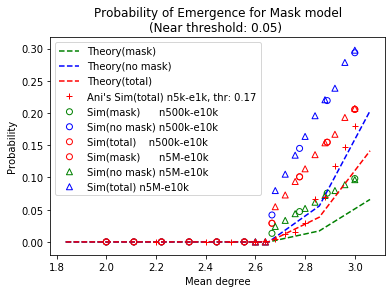

In [98]:
'''
Load raw data from Parellel & Play with threshold for PE
'''

degree_min = 0
degree_max = 10 # para md in simulation script
interval_num = 50 # para ns in simulation script
mean_degree_list = np.linspace(degree_min, degree_max, interval_num,)

thrVal0 = 0.05# works for m0.45_T0.60_tm1_0.30_tm2_0.70
thrVal1 = 0.05


# thrVal0 = 0.141
# thrVal1 = 0.141 # works for m0.6_T0.70_tm1_0.40_tm2_0.60

raw0, raw1, paras = load_sirius_rawdata('m', para_setting, exp_time='092713:26')
print(paras)
es0, pe0, mlist0 = resolve_sirius_raw(raw0, thrVal0)
es1, pe1, mlist1 = resolve_sirius_raw(raw1, thrVal1)

# raw0_, raw1_, paras_ = load_sirius_rawdata('m', para_setting, exp_time='092817:49')
raw0_, raw1_, paras_ = load_sirius_rawdata('m', para_setting, exp_time='100217:44')

print(paras_)
es0_, pe0_, mlist0_ = resolve_sirius_raw(raw0_, thrVal0)
es1_, pe1_, mlist1_ = resolve_sirius_raw(raw1_, thrVal1)

print(mlist0)
print(mlist1)

if len(mlist0) < len(mlist1):
    mlist = mlist0
    pe1 = pe1[: len(pe0)]
else:
    mlist = mlist1
    pe0 = pe0[: len(pe1)]
m = paras['m']
pe = pe0 * m + pe1 * (1 - m)
PE = PE0 * m + PE1 * (1 - m)

mlist = [float(i) for i in mlist]
mean_degree_list_plot = mlist
print('mlist', mlist)




mean_degree_list_plot_ = [2.6, 2.64, 2.68, 2.72, 2.76, 2.8, 2.84, 2.88, 2.92, 2.96, 3.0]

# start = np.where(mean_degree_list == mlist[0])[0][0]
# end   = np.where(mean_degree_list == max(mlist))[0][0]



# mean_degree_list_plot = mean_degree_list[start: end]
# PE0_plot = list(PE0)[start: end]
# PE1_plot = list(PE1)[start: end]
# PE_plot  = list(PE)[start: end]


'''
Plot PE analysis v.s. simulation
'''


fig, ax = plt.subplots()
# ax.plot(mean_degree_list_plot, PE0, 'g--')
# ax.plot(mean_degree_list_plot, PE1, 'b--')
# ax.plot(mean_degree_list_plot, PE, 'r--')

# start = 11 # M0.6
# end   = 16 # M0.6

start = 9

end   = 16

ax.plot(mean_degree_list[start:end], PE0[start:end], 'g--')
ax.plot(mean_degree_list[start:end], PE1[start:end], 'b--')
ax.plot(mean_degree_list[start:end], PE[start:end], 'r--')


ax.scatter(mean_degree_list_plot, pe0, facecolors='none', edgecolors='g')
ax.scatter(mean_degree_list_plot, pe1, facecolors='none', edgecolors='b')
ax.scatter(mean_degree_list_plot, pe0 * m + pe1 * (1 - m), facecolors='none', edgecolors='r')
ax.scatter(mean_degree_list_plot, pe, facecolors='none', edgecolors='r')

ax.scatter(mean_degree_list_plot_, pe0_, marker='^', facecolors='none', edgecolors='g')
ax.scatter(mean_degree_list_plot_, pe1_, marker='^', facecolors='none', edgecolors='b')
ax.scatter(mean_degree_list_plot_, pe0_ * m + pe1_ * (1 - m), marker='^', facecolors='none', edgecolors='r')

mean_degree_list_ani = [2.2, 2.4, 2.5, 2.6, 2.64, 2.68, 2.72, 2.76, 2.8, 2.84, 2.88, 2.92, 2.96, 3.0]
fractionDic_list = list(np.load('simulation_scripts/ani_thr_raw.npy'))
fractionDic_list = [list(i) for i in fractionDic_list]
# print(fractionDic)


# plt.plot(x_coordinates, y_coordinates, 'r-.')
pe_list = []
numExp = 1000
for idx, mean_degree in enumerate(mean_degree_list_ani):
    fractionDic = fractionDic_list[idx]
    # output average epidemic sizes
    av_epidemic_size = 0
    num_epidemics = 0
    for i in range(numExp):
        if fractionDic[i] >= 0.17:
            av_epidemic_size += fractionDic[i]
            num_epidemics += 1
    av_epidemic_size  = div(av_epidemic_size,num_epidemics)
    av_prob_emergence = div(num_epidemics, numExp)
    pe_list.append(av_prob_emergence)
#     print('Average size of the epidemic (conditioned on emergence) is ' + str(av_epidemic_size))
#     print('Average probability of emergence is ' + str(av_prob_emergence))
ax.plot(mean_degree_list_ani, pe_list, 'r+')


plt.legend([
            "Theory(mask)", 
            "Theory(no mask)",
#             "Threshold: 0.05",
            "Theory(total)",
    "Ani's Sim(total) n5k-e1k, thr: 0.17",
#             "Mutation theory(Q1)", 
#             "Mutation theory(Q2)",
            "Sim(mask)      n500k-e10k", 
            "Sim(no mask) n500k-e10k",
            "Sim(total)    n500k-e10k",
            "Sim(mask)      n5M-e10k", 
            "Sim(no mask) n5M-e10k",
            "Sim(total) n5M-e10k",
    
],)
plt.xlabel('Mean degree')
plt.ylabel('Probability')
print(para_setting)
title = "Probability of Emergence for Mask model\n(Near threshold: 0.05) "  
plt.title(title)

In [17]:
# # '''Load ES simulation results'''
# if0_sirius, if1_sirius, paras_sim = load_ES_sim_results(metric_analysis, para_setting,)
# exp_setting_es = "n" + str(paras_sim['n']) + "e" + str(paras_sim['e'])
# paras_sim

'''Load  simulation results(inclusing raw data) copied from happyfeet'''
'''
Notice: Ray results work for ES!!
'''
 
# happy_path = 'happyfeet/090602:32/ss1/'
# if0, if1, paras = load_happyfeet_ES_results(happy_path, from_sirius = False)



# # '''Load  simulation results from sirius(new path)'''
# sim_model_names = ['Mask2', ]
# # base_happy_path = 'happyfeet/'
# base_happy_path = 'simulation/'
# sim_metric = 'm'
# exp_setting = 'n5000_totalexp10000'
# sim_model_name = sim_model_names[0]

# if0, if1, paras, raw_ss1 = load_happyfeet_ES_results(base_happy_path, sim_metric, 
#                                     para_setting, 
#                                     exp_setting, 
#                                     sim_model_name, 
#                                     0)
# paras
# if0, if1, paras = load_happyfeet_results(happy_path, from_sirius = True)

'\nNotice: Ray results work for ES!!\n'

In [9]:
# '''Load  PE simulation results copied from happyfeet'''
# '''
# Notice: Ray results WORK for PE_0!!
# PE_0 and PE_1 are the both PE_0??????
# '''

# # happy_path_0 = 'happyfeet/090602:32/ss1/'
# # # happy_path_0 = 'Mask2Results_change_m/m0.2_T0.60_tm1_0.40_tm2_0.60/n50_totalexp10/091420:52/ss1/'
# # pe0, paras = load_happyfeet_PE_results(happy_path_0, start_strain=0, from_sirius = False)

# # happy_path_1 = 'happyfeet/090602:32/ss2/'
# # # happy_path_1 = 'Mask2Results_change_m/m0.2_T0.60_tm1_0.40_tm2_0.60/n50_totalexp10/091420:52/ss2/'
# # pe1, paras = load_happyfeet_PE_results(happy_path_1, start_strain=1, from_sirius = False)

# # '''Load PE simulation results'''
# metric_analysis = 'm'
# para_setting = 'm0.45_T0.60_tm1_0.30_tm2_0.70'
# exp_time = '092306:26'
# pe0_sirius, pe1_sirius, paras_sim = load_PE_sim_results(metric_analysis, para_setting, exp_time )
# exp_setting_pe = "n" + str(paras_sim['n']) + "e" + str(paras_sim['e'])
# paras_sim

# # '''Load  simulation results from sirius(new path)'''
# # sim_model_names = ['Mask2', ]
# # base_happy_path = 'simulation/'
# # sim_metric = 'm'
# # exp_setting = 'n5000_totalexp10000'
# # sim_model_name = sim_model_names[0]

# # pe0, paras = load_happyfeet_PE_results(base_happy_path, 
# #                                             sim_metric, 
# #                                             para_setting, 
# #                                             exp_setting, 
# #                                             sim_model_name, 
# #                                             start_strain=0)
# # pe1, paras = load_happyfeet_PE_results(base_happy_path, 
# #                                             sim_metric, 
# #                                             para_setting, 
# #                                             exp_setting, 
# #                                             sim_model_name, 
# #                                             start_strain=1)
# # paras

{'n': 5000000,
 'e': 1000,
 'm': 0.45,
 'T': 0.6,
 'tm1': 0.3,
 'tm2': 0.7,
 'th': 0.3,
 'md': 10,
 'ns': 50}